Libraries

In [1]:
import torch
import numpy as np
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

















Device

In [2]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print("Using device:", device)

Using device: cuda


Loading dataset

In [3]:
data_path= "../data/"
IMG_HEIGHT= 48
IMG_WIDTH= 48
BATCH_SIZE= 64

DATA PREPARING

In [4]:
train_transform= transforms.Compose([
    transforms.Grayscale(num_output_channels= 1),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness= 0.2),
    transforms.ToTensor(), # convert to tensor format
    transforms.Normalize(mean= [0.5], std= [0.5])
])
val_transform= transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Grayscale(num_output_channels= 1),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.5], std= [0.5])
])
train_dataset_full= datasets.ImageFolder(data_path, transform= train_transform)
val_dataset_full= datasets.ImageFolder(data_path, transform= val_transform)
num_samples= len(train_dataset_full)
indices= list(range(num_samples))
labels= train_dataset_full.targets
train_idx, temp_idx= train_test_split(
    indices,
    test_size= 0.2,
    shuffle= True,
    stratify= labels,
    random_state= 42
)
val_idx, test_idx= train_test_split(
    temp_idx,
    test_size= 0.5,
    shuffle= True,
    random_state= 42
)
train_data= Subset(train_dataset_full, train_idx)
val_data= Subset(val_dataset_full, val_idx)
test_data= Subset(val_dataset_full, test_idx)

train_loader= DataLoader(train_data, batch_size= BATCH_SIZE, shuffle= True, num_workers= 2)
val_loader= DataLoader(val_data, batch_size= BATCH_SIZE, shuffle= False, num_workers= 2)
test_loader= DataLoader(test_data, batch_size= BATCH_SIZE, shuffle= False, num_workers= 2)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {(len(val_data))}")
print(f"Test size: {len(test_data)}")





Train size: 47279
Validation size: 5910
Test size: 5910


MODEL CLASS

In [5]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
    
        self.conv1= nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= 3, padding= 1)
        self.bn1= nn.BatchNorm2d(32)
        
        self.conv2= nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, padding= 1)
        self.bn2= nn.BatchNorm2d(64)

        self.conv3= nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, padding=1)
        self.bn3= nn.BatchNorm2d(128)

        self.conv4= nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, padding= 1)
        self.bn4= nn.BatchNorm2d(256)
       

        self.pool= nn.MaxPool2d(2, 2)
        
        self.dropout= nn.Dropout(0.25)
        
        self.fc1= nn.Linear(256*3*3, 512)
       
        self.fc2= nn.Linear(512, num_classes)
        

    def forward(self, x):
        x= self.pool(F.relu(self.bn1(self.conv1(x))))
        x= self.dropout(x)

        x= self.pool(F.relu(self.bn2(self.conv2(x))))
        x= self.dropout(x)

        x= self.pool(F.relu(self.bn3(self.conv3(x))))
        x= self.dropout(x)

        x= self.pool(F.relu(self.bn4(self.conv4(x))))
        x= self.dropout(x)

        x= x.view(-1, 256*3*3)
        x= F.relu(self.fc1(x))
        x= self.dropout(x)
        x= self.fc2(x)
        return x


SETUP TRAINING

In [6]:



num_classes = 5  
model = EmotionCNN(num_classes).to(device)



criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

TRAINING LOOP

In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss= 0.0
    correct= 0
    total= 0

    loop= tqdm(loader, leave= False)
    

    for images, labels in loop:
    
        images, labels= images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none= True)
        outputs= model(images)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_size= labels.size(0)
        
        running_loss += loss.item()*batch_size
        
        _, predicted= torch.max(outputs.detach(), 1)
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_description(f"Loss: {loss.item():.4f}")
    avg_loss= running_loss/ total
    accuracy= 100*correct/total
    return avg_loss, accuracy
def validation_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss= 0.0
    correct= 0
    total= 0
    with torch.no_grad(): 
        for images, labels in loader: 
            images, labels= images.to(device), labels.to(device)
            outputs= model(images)
            loss= criterion(outputs, labels)
            batch_size= labels.size(0)
            running_loss += loss.item()*batch_size
            
            _, predicted= torch.max(outputs.detach(), 1)
            
            total+=labels.size(0)
            correct += (predicted ==labels).sum().item()
    avg_loss= running_loss/ total
    accuracy= 100*correct/total
    return avg_loss, accuracy


Early stopping

In [8]:
class EarlyStopping:
    def __init__(self, patience= 7, min_delta= 0, path= 'best_model_loss.pth'):
        self.patience= patience
        self.min_delta= min_delta
        self.counter= 0
        self.best_loss= None
        self.early_stop= False
        self.path= path
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss= val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss= val_loss
            self.save_checkpoint(val_loss, model)
            self.counter= 0
        else:
            self.counter += 1
            if self.counter > self.patience:
                self.early_stop= True
    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...")

Scheduler

In [9]:
num_epochs= 50
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= 3, factor= 0.1)
early_stopping= EarlyStopping(patience= 7, path= 'best_model_loss.pth')

MAIN EXECUTION LOOP

In [ ]:

history= {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc= 0.0
print('start training...')

for epoch in range(num_epochs):
    train_loss, train_acc= train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc= validation_one_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch: [{epoch+1}/{num_epochs}]")
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc= val_acc
        torch.save(model.state_dict(), 'best_model_acc.pth')
        print("save the best model")
    if early_stopping.early_stop:
        print("Early stopping")
        break


VISUALIZATION


In [ ]:
def plot_history(history):
    plt.figure(figsize= (12, 5))
    plt.subplot(1 ,2, 1)
    plt.plot(history['train_loss'], label= 'Train loss')
    plt.plot(history['val_loss'], label= 'Val loss')
    plt.title('Loss history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()

    plt.figure(figsize= (12, 5))
    plt.subplot(1 ,2, 1)
    plt.plot(history['train_acc'], label= 'Train accuracy')
    plt.plot(history['val_acc'], label= 'Val accuracy')
    plt.title('Accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)') 
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

In [10]:
import os
print(os.getcwd())
print(os.listdir())

c:\Users\ADMIN\Human face emotions prediction\model
['anh1.jpg', 'anh2.jpg', 'anh3.jpg', 'anh4.jpg', 'anh5.jpg', 'anh6.jpg', 'best_model_acc_final.pth', 'best_model_loss.pth', 'nhennho.jpg', 'training.ipynb']


Evaluation on test set

load successfully
running on test set ...

Class names: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']

TEST ACCURACY: 83.49%

Confusion Matrix:
              precision    recall  f1-score   support

       Angry       0.81      0.78      0.80      1026
        Fear       0.80      0.64      0.71       995
       Happy       0.92      0.95      0.94      1783
         Sad       0.74      0.82      0.78      1277
     Suprise       0.86      0.91      0.88       829

    accuracy                           0.83      5910
   macro avg       0.83      0.82      0.82      5910
weighted avg       0.84      0.83      0.83      5910



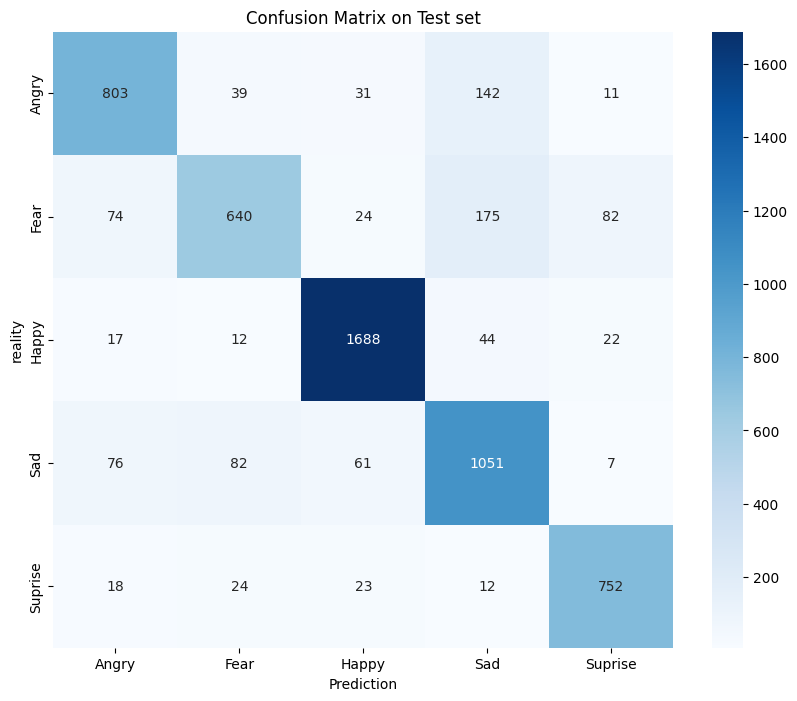

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=5).to(device) 

path_best_model = 'best_model_acc_final.pth' 

try:
    model.load_state_dict(torch.load(path_best_model, map_location=device))
    print("load successfully")
except:
    print("file not found")


def test_model(model, loader):
    model.eval() 
    all_preds = []
    all_labels = []
    
    print("running on test set ...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_labels), np.array(all_preds)


y_true, y_pred = test_model(model, test_loader)


class_names = train_dataset_full.classes 
print(f"\nClass names: {class_names}")


acc = np.mean(y_true == y_pred)
print(f"\nTEST ACCURACY: {acc*100:.2f}%")


print("\nConfusion Matrix:")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('reality')
plt.title('Confusion Matrix on Test set')
plt.show()

Prediction result: Surprise - Confidence: 80.68%


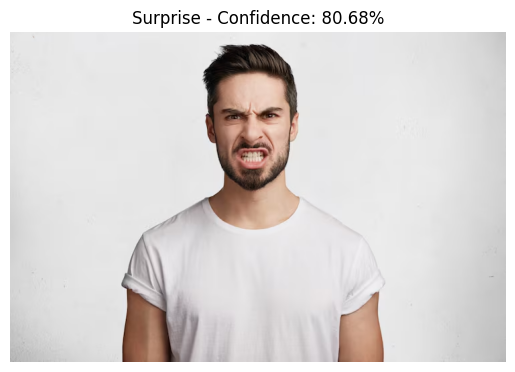

In [52]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class_labels = {
    0: 'Angry',
    
    1: 'Fear',
    2: 'Happy',
    3: 'Sad',
    4: 'Surprise',
    
}

inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


def predict_single_image(image_path, model_path):
    
    model = EmotionCNN(num_classes=5).to(device)
    
    try:
        
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval() 
    except Exception as e:
        return f"Model loading eror: {e}", None

    
    try:
        
        img_raw = Image.open(image_path)
        
        
        img_tensor = inference_transform(img_raw)
        
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
    except Exception as e:
        return f"Reading eror: {e}", None

    
    with torch.no_grad():
        outputs = model(img_tensor)
        
        
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        
        idx = predicted_class.item()
        score = confidence.item() * 100
        
        result_text = f"{class_labels[idx]} - Confidence: {score:.2f}%"
        
        return result_text, img_raw


img_path = 'anh3.jpg'  
model_path = 'best_model_acc_final.pth' 


result, image = predict_single_image(img_path, model_path)

print("Prediction result:", result)


if image:
    plt.imshow(image)
    plt.title(result)
    plt.axis('off')
    plt.show()

Face detection added

Find 1 face(s).


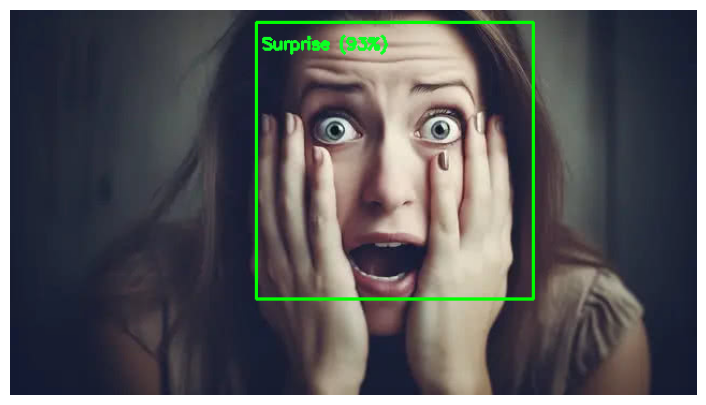

In [41]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=5).to(device)
model.load_state_dict(torch.load('best_model_acc_final.pth', map_location=device))
model.eval()

class_labels = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise'}

def predict_real_world_image(image_path):
   
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    
    img_cv2 = cv2.imread(image_path)
    if img_cv2 is None: return "image not found"
    
    gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
    
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return "no faces found"

    print(f"Find {len(faces)} face(s).")
    
    
    plt.figure(figsize=(10, 5))
    
    for i, (x, y, w, h) in enumerate(faces):
       
        face_roi = gray[y:y+h, x:x+w]
        
        
        pil_img = Image.fromarray(face_roi)
        
        
        img_tensor = inference_transform(pil_img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            conf, pred = torch.max(probs, 1)
            
        label = class_labels[pred.item()]
        score = conf.item() * 100
        
        
        cv2.rectangle(img_cv2, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_cv2, f"{label} ({score:.0f}%)", (x+5, y+25), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)

    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


predict_real_world_image('surprise.jpg')